In [2]:
import json
import pandas as pd
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)

class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def load_transformer(self, name):
        self.model = SentenceTransformer.load(name)
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            for i in steps:
                sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return max_

punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
# model = SentenceTransformer('DeepPavlov/rubert-base-cased')

In [6]:
# model.save('./models/Pavlov-rubert')

In [7]:
model = SentenceTransformer.load('./models/Pavlov-rubert')

In [8]:
match_unmatch_df = read_json('./dataset.json')

In [47]:
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]

modelResearcher_rubert = ModelResearcher()
modelResearcher_rubert.load_transformer('./models/Pavlov-rubert')
df_train_f1, df_test_f1 = modelResearcher_rubert.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [11]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size, match_unmatch_df['id_rp'].size))

df_train: 22 of 46
df_test: 22 of 46


In [12]:
from sentence_transformers import SentenceTransformer

modelR = SentenceTransformer('DeepPavlov/rubert-base-cased')

No sentence-transformers model found with name C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly id

### Наивные методы

0
Optimal threshold: 0.688


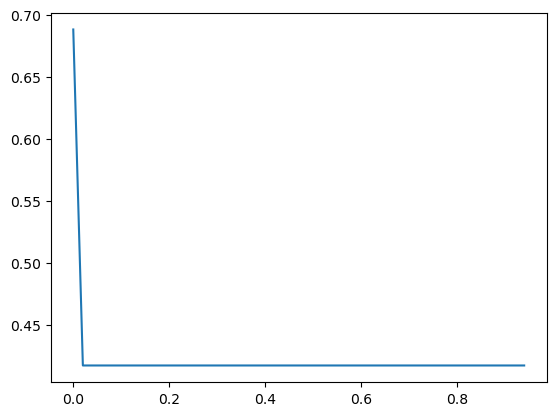

<Figure size 1000x300 with 0 Axes>

In [36]:
# дурацкие методы

import random

def match_naive(text_1, text_2):
    return int((len(text_1) + len(text_2)) % 2 == 0)

def match_rand(text_1, text_2):
    return int(bool(random.getrandbits(1)))

threshold = 0
thresholds = []
max_ = 0
print(max_)
step = 0.02 
from_ = 0.0
to = 0.94
h = from_
steps = np.linspace(from_, to, num=int((to - from_)/step))
steps = np.round(steps, 2)
for i in steps:
    sim = []
    for text_rp, text_proj in zip(df_train_f1['text_rp'], df_train_f1['text_proj']):
        sim += [match_naive(text_rp, text_proj)] 
    threshold = calc_f1_score(sim, df_train_f1, h)
    thresholds.append(threshold)
    # print(threshold)
    if threshold > max_:
        max_ = threshold
        # print(max_, threshold)
    h += step

print(f'Optimal threshold: {max_}')
plt.plot(steps, thresholds)
plt.figure(figsize=(10,3))
plt.show()

### Сравнить каждое предложение текста_1 и текста_2, и оценить каждое предложение по топ-5 совпадений в другом тексте

In [37]:
import re


def sent_preprocess(text:str):
    preprocessed_text = sent_tokenize(text)
    for i in range(len(preprocessed_text)):
        res = re.sub(r'([^\w\s])|([0-9]+)', '', preprocessed_text[i])
        # res = re.sub(r'', '' ,  res)
        preprocessed_text[i] = res
    return preprocessed_text

In [58]:
for pair in zip(df_train_f1['text_rp'], df_train_f1['text_proj']):
    sentences_rp = sent_preprocess(pair[0])
    sentence_embeddings_rp = []

    sentences_proj = sent_preprocess(pair[1])
    sentence_embeddings_proj = []
    sim = []
    if len(sentences_rp) > len(sentences_proj):
        sentences_rp = sentences_rp[:len(sentences_proj)]
    else:
        sentences_proj = sentences_proj[:len(sentences_rp)]

    for sentence in sentences_rp:
        sentence_embeddings_rp.append(modelR.encode(sentence, convert_to_tensor=True))
    
    for sentence in sentences_proj:
        sentence_embeddings_proj.append(modelR.encode(sentence, convert_to_tensor=True))
    # print(len(sentence_embeddings_proj), len(sentence_embeddings_rp))
    
    for j in range(len(sentence_embeddings_rp)):
        sim += [float(util.pytorch_cos_sim( sentence_embeddings_rp[j], sentence_embeddings_proj[j]))]
        # print(f'Предложение рабочей программы: {sentences_rp[j]}\n' + 
        #       f'Предложение проекта: {sentences_proj[j]}\n'
        #       + f'Совпадение: {sim[len(sim) - 1]}\n\n')
    pairs = []
    for j in range(len(sim)):
        pairs += [sentences_rp[j], sentences_proj[j], sim[j]]
        


Предложение рабочей программы: Дисциплина посвящена изучению современных подходов к разработке программных систем устойчивых к вредоносным воздействиям
Предложение проекта: Стажировка в Digital Security по аудиту защищённости ПО
Совпадение: 0.6447359323501587


Предложение рабочей программы: Рассматриваются методы атак на программные системы такие как повреждения программной памяти внедрение кода на стороне клиента или сервера и др а также методики и свойства современных языков программирования для предотвращения появления уязвимостей подобного рода Дисциплина нацелена на получение теоретических знаний о классификации основных уязвимостей в программном обеспечении подходах к разработке защищенного программного обеспечения и приобретение практических навыков применения полученных теоретических знаний для решения задач профессиональной деятельности
Предложение проекта: Summr f hck 
Совпадение: 0.19819165766239166


Предложение рабочей программы: Задачами дисциплины является приобретение 

### Подбор оптимального порога, на котором F1-score максимален (старый)

In [21]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim) - 1):
        if len(df['need_match'][i:i+1].tolist()):
            if df['need_match'][i:i+1].tolist()[0]:
                if sim[i] >= match_threshold: 
                    TP += 1
                else:
                    FN += 1
            else:
                if sim[i] >= match_threshold: 
                    FP += 1
                else:
                    TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)


In [ ]:
threshold = 0
thresholds = []
max_ = 0
step = 0.02 
from_ = 0.5
to = 0.94
h = from_
steps = np.linspace(from_, to, num=int((to - from_)/step))
steps = np.round(steps, 2)
print(steps)
sentence_embeddings_rp = []
sentence_embeddings_proj = []
for i in steps:
    for item in df_train_f1['text_rp']:
        sentence_embeddings_rp.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))

    for item in df_train_f1['text_proj']:
        sentence_embeddings_proj.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))
        
    for j in range(len(sentence_embeddings_rp)):
        sim += util.pytorch_cos_sim( sentence_embeddings_rp[j], sentence_embeddings_proj[j])
    threshold = calc_f1_score(sim, df_train_f1, h)
    print(h, threshold)
    thresholds.append(threshold)
    if threshold > max_:
        max_ = threshold
    h += step
plt.plot(steps, thresholds)
plt.figure(figsize=(10,3))
plt.show()